In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from matplotlib import pyplot as plt 
import networkx as nx 
import pandas as pd 

In [2]:
from dotenv import load_dotenv
import os, sys

load_dotenv()

# Load PROJECT_ROOT
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add PROJECT_ROOT to sys.path
sys.path.append(PROJECT_ROOT)

In [3]:
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, "output", "cs_2023-04-01.routes.csv"))
# Column names: flight_id	real_waypoints	pass_times	speeds	real_full_waypoints	full_pass_times	full_speeds
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _MF6J1HdT BIRES_29 _MgIeEfts _bJVLVAhA _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _TDyhe7PE _EhaHf4K2 SOBOS_91 _Z74cvhxb _4s...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _bs3fYMZv ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _0bKYrXD8 _2kVPBh5d LUMED _KwLOjVJW _2QG...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851


In [4]:
# Load the waypoints graph (nodes only)
ats_fra_graph = nx.read_gml(os.path.join(PROJECT_ROOT, "data", "graphs", "ats_fra_nodes_only.gml"))
print(f"ATS-FRA graph has {ats_fra_graph.number_of_nodes()} nodes and {ats_fra_graph.number_of_edges()} edges")

ATS-FRA graph has 33763 nodes and 0 edges


In [5]:
from utils.haversine import haversine_distance

# Function to extract first and last waypoints from the route
def get_first_last_waypoints(waypoints_str):
    waypoints = waypoints_str.split()
    if len(waypoints) < 2:
        return None, None
    return waypoints[0], waypoints[-1]

# Calculate the great circle distance for each route
def calculate_gc_distance(row):
    first_wp, last_wp = get_first_last_waypoints(row['real_waypoints'])
    
    if first_wp is None or last_wp is None:
        return np.nan
    
    try:
        # Get coordinates from the graph
        first_node = ats_fra_graph.nodes[first_wp]
        last_node = ats_fra_graph.nodes[last_wp]
        
        # Calculate distance
        distance = haversine_distance(
            first_node['lat'], first_node['lon'],
            last_node['lat'], last_node['lon']
        )
        return distance
    except KeyError:
        # Handle case where waypoint is not in the graph
        return np.nan

# Add the route_gc_length column to the dataframe
routes_df['route_gc_length'] = routes_df.apply(calculate_gc_distance, axis=1)

# Display the first few rows with the new column
routes_df.head()


,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _MF6J1HdT BIRES_29 _MgIeEfts _bJVLVAhA _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _TDyhe7PE _EhaHf4K2 SOBOS_91 _Z74cvhxb _4s...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _bs3fYMZv ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _0bKYrXD8 _2kVPBh5d LUMED _KwLOjVJW _2QG...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133


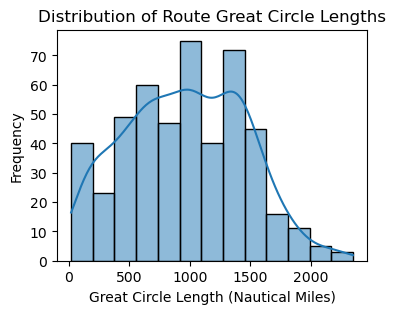

In [6]:
# Create a histogram of route great circle lengths using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.histplot(data=routes_df, x='route_gc_length', kde=True)
plt.title('Distribution of Route Great Circle Lengths')
plt.xlabel('Great Circle Length (Nautical Miles)')
plt.ylabel('Frequency')
plt.show()


# Binning ODs

In [18]:
# From routes_df, add two columns: first_wp and last_wp
routes_df['first_wp'] = routes_df['real_waypoints'].str.split().str[0]
routes_df['last_wp'] = routes_df['real_waypoints'].str.split().str[-1]
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length,first_wp,last_wp,origin_grid_id,destination_grid_id,od_id
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803,INKIM,MALTI,85:28,71:28,85:28x71:28
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _MF6J1HdT BIRES_29 _MgIeEfts _bJVLVAhA _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418,LAKTO,LCLK,65:64,69:67,65:64x69:67
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _TDyhe7PE _EhaHf4K2 SOBOS_91 _Z74cvhxb _4s...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463,LCA,SISIM,69:67,64:64,69:67x64:64
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _bs3fYMZv ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254,TANSA_98,REXUN,68:52,67:28,68:52x67:28
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _0bKYrXD8 _2kVPBh5d LUMED _KwLOjVJW _2QG...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133,ODGAX,METRU_30,67:27,68:50,67:27x68:50


In [19]:
def get_grid_id(wp):
    """
    Get the grid ID for a waypoint based on its latitude and longitude.
    
    Args:
        wp (str): Waypoint name
    
    Returns:
        str: Grid ID in the format 'lat_lon'
    """
    try:
        node = ats_fra_graph.nodes[wp]
        lat = node['lat']
        lon = node['lon']
        
        lat_grid = int(lat / 1.0)
        lon_grid = int(lon / 1.0)
        
        return f"{lat_grid}:{lon_grid}"
    except KeyError:
        return np.nan

In [20]:
# Add the grid ID to each origin and destination
routes_df['origin_grid_id'] = routes_df['first_wp'].apply(get_grid_id)
routes_df['destination_grid_id'] = routes_df['last_wp'].apply(get_grid_id)
routes_df['od_id'] = routes_df['origin_grid_id'] + 'x' + routes_df['destination_grid_id']
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length,first_wp,last_wp,origin_grid_id,destination_grid_id,od_id
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803,INKIM,MALTI,42:14,35:14,42:14x35:14
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _MF6J1HdT BIRES_29 _MgIeEfts _bJVLVAhA _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418,LAKTO,LCLK,32:32,34:33,32:32x34:33
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _TDyhe7PE _EhaHf4K2 SOBOS_91 _Z74cvhxb _4s...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463,LCA,SISIM,34:33,32:32,34:33x32:32
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _bs3fYMZv ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254,TANSA_98,REXUN,34:26,33:14,34:26x33:14
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _0bKYrXD8 _2kVPBh5d LUMED _KwLOjVJW _2QG...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133,ODGAX,METRU_30,33:13,34:25,33:13x34:25


In [23]:
ods = routes_df['origin_grid_id'].unique()
print(f'There are {len(ods)} unique origins in the routes_df, per {len(routes_df)} routes. Ratio: {len(ods)/len(routes_df)}')

There are 132 unique origins in the routes_df, per 486 routes. Ratio: 0.2716049382716049
